<a href="https://colab.research.google.com/github/machar94/stockprediction/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Optimization" data-toc-modified-id="Model-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Optimization</a></span></li></ul></div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

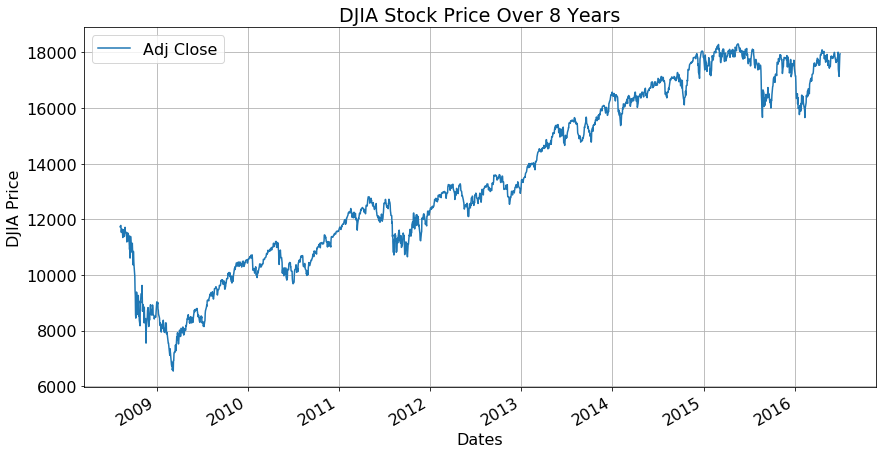

In [52]:
import talib
import numpy as np
import warnings
from os.path import isfile, join
from matplotlib import pyplot as plt
from functools import wraps
import pandas as pd
%matplotlib inline

# Open the data file
data_path = 'data/'
filename = 'djia.csv'
full_path = join(data_path, filename)
assert (isfile(full_path))

# Reads in data and checks to see none of the data is null
df = pd.read_csv(full_path)
assert (df.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df = df.sort_values(by='Date')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
df.plot(y='Adj Close', ax=ax)
ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [53]:
def plotSignal(func):
    @wraps(func)
    def wrapper(prices, signal, plot=False):
        func(prices, signal)

        if plot:
            plt.rcParams['font.size'] = 16
            fig = plt.figure(figsize=(8, 4))
            ax = fig.add_axes([0, 0, 1, 1])
            plt.plot(prices.index, signal['data'])
            ax.set_title(func.__name__)
            ax.set_xlabel('Dates')
            fig.autofmt_xdate(rotation=30)
            ax.grid()
            plt.show()

    return wrapper


@plotSignal
def sma(prices, signal):
    """
    Simple Moving Average
    """

    window = signal['params']['window']
    signal['data'] = talib.SMA(prices['close'], window).to_numpy()[:, None]


@plotSignal
def wma(prices, signal):
    """
    Weighted Moving Average
    """

    window = signal['params']['window']
    signal['data'] = talib.WMA(prices['close'], window).to_numpy()[:, None]


@plotSignal
def mom(prices, signal):
    """
    Momentum
    """

    window = signal['params']['window']
    signal['data'] = talib.MOM(prices['close'], window).to_numpy()[:, None]


@plotSignal
def macd(prices, signal):
    """
    Moving Average Convergence Divergence
    """

    fast = signal['params']['fastperiod']
    slow = signal['params']['slowperiod']
    mavg = signal['params']['signalperiod']

    macd, macdsignal, _ = talib.MACD(prices['close'], fast, slow, mavg)

    signal['data'] = np.hstack(
        [macd.to_numpy()[:, None],
         macdsignal.to_numpy()[:, None]])


@plotSignal
def rsi(prices, signal):
    """
    Relative Strength Index
    """

    window = signal['params']['window']
    signal['data'] = talib.RSI(prices['close'], window).to_numpy()[:, None]


@plotSignal
def stoch(prices, signal):
    """
    Stochastics
    """

    slowk, slowd = talib.STOCH(prices['high'], prices['low'], prices['close'])

    signal['data'] = np.hstack(
        [slowk.to_numpy()[:, None],
         slowd.to_numpy()[:, None]])


@plotSignal
def willr(prices, signal):
    """
    Williams R Oscillator
    """

    window = signal['params']['window']
    signal['data'] = talib.WILLR(prices['high'], prices['low'],
                                 prices['close'], window).to_numpy()[:, None]


@plotSignal
def adosc(prices, signal):
    """
    Accumulation / Distribution Oscillator
    """

    signal['data'] = talib.ADOSC(prices['high'],
                                 prices['low'],
                                 prices['close'],
                                 prices['volume'],
                                 fastperiod=3,
                                 slowperiod=10).to_numpy()[:, None]

In [54]:
# Other Helper Functions


def resetSignals(indicators):
    """
    Creates a signals structure given list of functions
    """
    signals = {}

    for func in indicators:
        signals[func.__name__] = {}
        signals[func.__name__]['func'] = func
        signals[func.__name__]['params'] = {}
        signals[func.__name__]['data'] = None

    return signals


def extractFeatures(prices, signals):
    """
    Calculate signals based on items in dictionary
    """
    for k, signal in signals.items():
        signal['func'](prices, signal, plot=False)

    return signals


def prepareLabels(prices, predict):
    """
    Calculates label depending on future price
    0 - price predict days ahead is down (trend down)
    1 - price predict days ahead is up (trend up)
    """

    # Because np.nan is represented as a large negative number,
    # wait to change labels to int type until after cleaning data
    close = prices['close']
    labels = np.full(close.shape, np.nan)
    for i in range(0, len(close) - predict):
        labels[i] = close[i + predict] - close[i]

    with warnings.catch_warnings():
        # Comparison with nan values creates warnings
        warnings.filterwarnings('ignore', 'invalid')
        labels[labels >= 0] = 1
        labels[labels < 0] = 0

    return labels


def getCleanData(prices, signals, predict=1, verbose=True):
    """
    Removes rows 
    """
    signals = extractFeatures(prices, signals)
    labels = prepareLabels(prices, predict)

    # Create a N x D matrix of samples vs features
    features = [v['data'] for _, v in signals.items()]
    features = np.hstack(features)

    # Remove rows with nans
    rowsbool = np.isnan(features).any(axis=1)
    rowsbool = np.logical_or(rowsbool, np.isnan(labels))
    rows = np.arange(features.shape[0])[rowsbool]

    if verbose:
        print(f'Removing the following times')
        print(f'============================')
        fmtr = lambda x: x.strftime('%Y/%m/%d')
        for row, time in zip(rows, dates[rows].format(formatter=fmtr)):
            print(f'row: {row:>4}   time: {time}')
    else:
        print(f'Removing {len(rows)} rows from data')

    features = features[~rowsbool, :]
    labels = labels[~rowsbool]

    return features, labels


def create_sequences(features, labels, seq_length):
    """
    Returns a (T,H,D) numpy array
    T - number of data points
    H - history size of lstm
    D - dimension of data X
    """

    N, D = features.shape
    T = N - seq_length + 1
    xs = np.empty((T, seq_length, D))
    ys = np.empty((T, 1), dtype=np.int)

    for i in range(T):
        xs[i] = np.copy(features[i:(i + seq_length), :])
        ys[i] = np.copy(labels[i])

    return xs, ys

In [73]:
prices = df.filter(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

names = {
    'High': 'high',
    'Low': 'low',
    'Volume': 'volume',
    'Adj Close': 'close'
}

prices.rename(columns=names, inplace=True)

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
]

# Prepare signals dictionary layout for uploading features
signals = resetSignals(technical_indicators)

# Set all signal parameters
signals['sma']['params']['window'] = 14
signals['wma']['params']['window'] = 14
signals['mom']['params']['window'] = 14
signals['macd']['params']['fastperiod'] = 12
signals['macd']['params']['slowperiod'] = 26
signals['macd']['params']['signalperiod'] = 9
signals['rsi']['params']['window'] = 14
signals['willr']['params']['window'] = 14

features, labels = getCleanData(prices, signals, predict=14, verbose=False)

Removing 47 rows from data


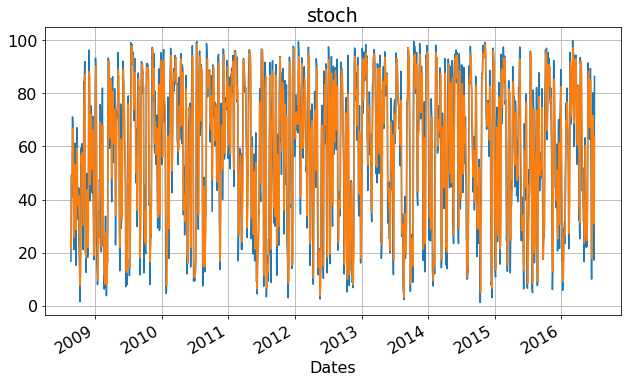

In [76]:
stoch(prices, signals['stoch'], plot=True)

In [63]:
# %pip install jupyterplot
import time, copy, torch
from torch import nn, optim
from jupyterplot import ProgressPlot
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

In [64]:
class Dataset(torch.utils.data.Dataset):
    """
    Characterizes a dataset for PyTorch
    """
    def __init__(self, data, labels):
        'Initialization'
        self.data = data
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [65]:
# Prepare data for nn training
batch_size = 14
n_features = features.shape[1]

# Want to perform this on full data set before splitting
# otherwise some numbers might be larger in validation set
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)
scaled = scaler.transform(features)

x_all, y_all = create_sequences(scaled, labels, seq_length=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_all,
                                                    y_all,
                                                    test_size=0.25,
                                                    random_state=seed)

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}
dataloaders = {
    x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

X Train Shape:  (1449, 10, 7)
X Test Shape:  (484, 10, 7)
Y Train Shape:  (1449, 1)
Y Test Shape:  (484, 1)


In [66]:
class Forecaster(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=2, dropout=0.5):
        super(Forecaster, self).__init__()

        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout,
        )

        # FC Layer
        self.FC = nn.Linear(self.n_hidden, 1)

    def forward(self, x):
        # (batch, seq, features) -> (seq, batch, features)
        lstm_out, self.hidden = self.lstm(torch.transpose(x, 0, 1))

        # lstm_out[-1] is (batch, hidden)
        y_pred = self.FC(lstm_out[-1]).sigmoid()

        return y_pred

In [67]:
class Solver():
    def __init__(self, model, **kwargs):
        """
        Required arguments:
        - model: a torch.nn model object
        """

        self.model = model

        # Unpack keyword arguments
        self.batch_size = kwargs.pop('batch_size', 10)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.mode = {}
        self.mode['plot'] = kwargs.pop('plot', False)
        self.mode['verbose'] = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

    def _reset(self):
        self.stats = {}
        self.stats['train'] = {
            x: np.zeros(self.num_epochs)
            for x in ['loss', 'acc']
        }
        self.stats['val'] = {
            x: np.zeros(self.num_epochs)
            for x in ['loss', 'acc']
        }

        # Enable GPU if available
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")

        if self.mode['verbose']:
            print(f'Using {self.device} for training.')

        self.best_val_acc = 0
        self.best_params = copy.deepcopy(self.model.state_dict())

        # Plotting setup
        if self.mode['plot']:
            self.pp = ProgressPlot(plot_names=['loss', 'acc'],
                                   line_names=['train', 'val'],
                                   x_lim=[0, self.num_epochs],
                                   y_lim=[0, 1])

    def _accuracy(self, preds, targets):
        # Convert to numpy since we don't want grad
        with torch.no_grad():
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            return torch.sum(torch.eq(preds, targets)).item()

    def _plotStats(self, epoch):
        data = [[
            self.stats['train']['loss'][epoch],
            self.stats['val']['loss'][epoch]
        ], [
            self.stats['train']['acc'][epoch], 
            self.stats['val']['acc'][epoch]
        ]]

        self.pp.update(data)

    def setModel(self, model):
        self.model = model

    def train(self, dataloaders, dataset_sizes):
        self._reset()

        loss_fn = nn.BCELoss()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # Prepare model for running
        self.model.double()
        self.model.to(self.device)

        since = time.time()
        for epoch in range(self.num_epochs):
            for phase in ['train', 'val']:

                if phase == 'train':
                    self.model.train()
                if phase == 'val':
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        # Forward pass
                        y_preds = self.model(inputs)
                        loss = loss_fn(y_preds, labels.double())

                        batch_size = inputs.shape[0]
                        if phase == 'train':
                            loss.backward()  # Calculate gradients
                            optimizer.step()  # Update weights

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += self._accuracy(y_preds, labels)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]

                # Deep copy the model
                if phase == 'val' and epoch_acc > self.best_val_acc:
                    self.best_val_acc = epoch_acc
                    self.best_params = copy.deepcopy(self.model.state_dict())

                if self.mode['verbose']:
                    print('Epoch: {}-{:6>0} Loss: {:.4f} Acc: {:.4f}'.format(
                        epoch + 1, phase, epoch_loss, epoch_acc))

                self.stats[phase]['loss'][epoch] = epoch_loss
                self.stats[phase]['acc'][epoch] = epoch_acc

            # Realtime results plotting
            if self.mode['plot']:
                self._plotStats(epoch)

        if self.mode['verbose']:
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            print('Best val acc: {:4f}'.format(self.best_val_acc))

        # Makes the plot persist across notebook sessions
        if self.mode['plot']:
            self.pp.finalize()

        # Reset model to return with the best parameters
        self.model.load_state_dict(self.best_params)

        return self.model.eval()

In [68]:
model = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, dropout=0.5)
solver = Solver(model,
                batch_size=batch_size,
                num_epochs=20,
                verbose=True,
                plot=True)

model = solver.train(dataloaders, dataset_sizes)

Using cpu for training.


Epoch: 1-train Loss: 0.6546 Acc: 0.6197
Epoch: 1-val Loss: 0.6318 Acc: 0.6219
Epoch: 2-train Loss: 0.5983 Acc: 0.6743
Epoch: 2-val Loss: 0.5964 Acc: 0.6798
Epoch: 3-train Loss: 0.5519 Acc: 0.7246
Epoch: 3-val Loss: 0.5596 Acc: 0.7107
Epoch: 4-train Loss: 0.5271 Acc: 0.7350
Epoch: 4-val Loss: 0.5733 Acc: 0.7211
Epoch: 5-train Loss: 0.5176 Acc: 0.7516
Epoch: 5-val Loss: 0.5545 Acc: 0.7293
Epoch: 6-train Loss: 0.5170 Acc: 0.7502
Epoch: 6-val Loss: 0.5429 Acc: 0.7252
Epoch: 7-train Loss: 0.5072 Acc: 0.7405
Epoch: 7-val Loss: 0.5436 Acc: 0.7252
Epoch: 8-train Loss: 0.5055 Acc: 0.7474
Epoch: 8-val Loss: 0.5437 Acc: 0.7211
Epoch: 9-train Loss: 0.5025 Acc: 0.7502
Epoch: 9-val Loss: 0.5366 Acc: 0.7190
Epoch: 10-train Loss: 0.4999 Acc: 0.7564
Epoch: 10-val Loss: 0.5405 Acc: 0.7252
Epoch: 11-train Loss: 0.5065 Acc: 0.7488
Epoch: 11-val Loss: 0.5333 Acc: 0.7231
Epoch: 12-train Loss: 0.4934 Acc: 0.7578
Epoch: 12-val Loss: 0.5439 Acc: 0.7211
Epoch: 13-train Loss: 0.4941 Acc: 0.7460
Epoch: 13-val Los

### Model Optimization

In [ ]:
%pip install scikit-optimize
from sklearn.model_selection import cross_val_score
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

In [ ]:
# Define the space of hyperparameters to search
search_space = [
    Integer(2, 128, name='n_hidden'),
    Integer(2, 4, name='n_layers'),
    Real(0.5, 0.9, name='dropout')
]


def cross_val_score(params, X, y, cv=5):

    n_hidden = int(params['n_hidden'])
    n_layers = int(params['n_layers'])
    droupout = params['dropout']

    # Split the data
    folds_x = np.array_split(X, cv)
    folds_y = np.array_split(y, cv)

    results = np.zeros(shape=(cv, ))

    for i in range(cv):
        # Make a copy of the set
        X_train = folds_x.copy()
        y_train = folds_y.copy()

        # Remove the specific fold
        X_test = folds_x[i]
        y_test = folds_y[i]

        del X_train[i]
        del y_train[i]

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        # Create dataloaders expected by solver
        data_sets = {
            'train': Dataset(X_train, y_train),
            'val': Dataset(X_test, y_test)
        }
        dataloaders = {
            x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True)
            for x in ['train', 'val']
        }
        dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

        # Run model and report best validation accuracy
        model = Forecaster(n_features=n_features,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           dropout=droupout)

        solver = Solver(model,
                        batch_size=batch_size,
                        num_epochs=30,
                        verbose=False)
        model = solver.train(dataloaders, dataset_sizes)

        results[i] = solver.best_val_acc

    return results


@use_named_args(search_space)
def evaluate_model(**params):
    print(f'Evaluating model with parameters: {params}')

    # Calculate K-fold cross validation
    result = cross_val_score(params, x_all, y_all, cv=5)
    # Calculate the mean of the scores
    estimate = np.mean(result)

    return 1.0 - estimate

In [ ]:
# Perform optimization
result = gp_minimize(evaluate_model, search_space, n_calls=20)

In [ ]:
GP_Bayes_Result = result

In [ ]:
print(GP_Bayes_Result)

In [ ]:
print(GP_Bayes_Result.x)
print(GP_Bayes_Result.fun)